## Summary of the notebook

Dropout model trained in the notebook : GBP_CHD_dropout_training.ipynb

**train configuration**  <br>
eager exeuction = enabled

**process**
1. Load the dropout trained model from the path 
2. Pass this model obtained in step 1 and the number of samples to be considered (to compute the prediction mean and prediction std) to StochasticRegressor class
3. The StochasticRegressor returns a stochastic model that can yield prediction mean and prediction std 
4. Using thoe model obtained in 3, we call the predict_output() that returns prediction mean, prediction std and the samples (from which these mean and std can be calculated)
5. Plot these prediction mean and prediction std against the ground truth to check the stochastic behaviour of the model 
6. For the number of samples, run a loop. Every time the explanation method is called, it returns the explanation (gradient of output wrt input) for that particaular sample of shape (1, 8) and the sample prediction itself (1, 1)
7. Using the sample explanation (of shape (1,8)), for say 20 samples of mcdropout (Yields an explanation matrix of (20, 8)), compute the mean explanation (1, 8) and std explanation (1, 8).  From the 20 sample prediction themselves (20, 1) compute the mean prediction (1, 1) and std prediction (1, 1). 

**checks**: ensure that the layers for which the GBP being computed is relevant/correct [should be the layer that yields the regression output]


## Mount the drive 

In [ ]:
# mount the drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Setting the correct path

In [ ]:
import os

project_path = '/content/drive/MyDrive/MasterThesis'
task_name = 'CaliforniaHousingDatasetTests'
exp_name = 'GBP_explanation'
uncert_name = 'dropout'

%cd /content/drive/MyDrive/MasterThesis/ 

print(os.getcwd())
path = project_path + '/' + task_name + '/' + exp_name + '/' + uncert_name + '/' # 'CaliforniaHousingDatasetTests/GBP_explanation/flipout/'
print(path)

saved_model_path = os.path.join(path, 'saved_models')
print(saved_model_path)

explanation_path = os.path.join(path, 'explanation_files')
print(explanation_path)

explanation_heatmap_path = os.path.join(path, 'explanation_heatmaps')
print(explanation_heatmap_path)

/content/drive/MyDrive/MasterThesis
/content/drive/MyDrive/MasterThesis
/content/drive/MyDrive/MasterThesis/CaliforniaHousingDatasetTests/GBP_explanation/dropout/
/content/drive/MyDrive/MasterThesis/CaliforniaHousingDatasetTests/GBP_explanation/dropout/saved_models
/content/drive/MyDrive/MasterThesis/CaliforniaHousingDatasetTests/GBP_explanation/dropout/explanation_files
/content/drive/MyDrive/MasterThesis/CaliforniaHousingDatasetTests/GBP_explanation/dropout/explanation_heatmaps


## Removing previous plots and explanations

In [ ]:
import glob, os, os.path
output_plot_path = path+'output_plots/'
filelist_pdf = glob.glob(os.path.join(output_plot_path, '*.pdf'))
filelist_png = glob.glob(os.path.join(output_plot_path, '*.png'))

# removing pdf explanatiosn 
for f in filelist_pdf:
    print(f'removing file {f}')
    os.remove(f)

for f in filelist_png:
    print(f'removing file {f}')
    os.remove(f)

removing file /content/drive/MyDrive/MasterThesis/CaliforniaHousingDatasetTests/GBP_explanation/dropout/output_plots/dropout_vs_prediction.pdf
removing file /content/drive/MyDrive/MasterThesis/CaliforniaHousingDatasetTests/GBP_explanation/dropout/output_plots/dropout_vs_prediction.png


## Imports 

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import tensorflow as tf

import os
import time
import random 
import math

from keras.layers import *
from keras.models import Model, Sequential
import keras.backend as K

print(tf.__version__)
print(f'Eager execution enabled : {tf.executing_eagerly()}')

import sys
sys.path.insert(0,'/content/drive/My Drive/MasterThesis/src/')

from utils import *

2.8.0
Eager execution enabled : True


## Load Data


In [ ]:
train_data, train_labels, val_data, val_labels, test_data, test_labels, feature_names = load_california_housing_data()

# following code to test the replicability of data split
#print(train_labels[20])
#print(val_labels[30])
#print(test_labels[40])

['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']
Training data shape 
 (12750, 8)
Training labels shape 
 (12750, 1)
Validation data shape 
  (4250, 8)
Validation labels shape 
  (4250, 1)
Test data shape 
  (3000, 8)
Test labels shape 
  (3000, 1)


## Class definitions

### StochasticModel & StochasticRegressor

In [ ]:
import numpy as np
import tensorflow as tf 
import tensorflow.keras.backend as K

Layer = tf.keras.layers.Layer
Dropout = tf.keras.layers.Dropout


class StochasticDropout(Dropout):
    """
        Applies Dropout to the input, independent of the training phase.
        Used to easily implement MC-Dropout. It is a drop-in replacement for
        the standard Keras Dropout layer, but note that this layer applies
        dropout at the training and inference phases.
    """
    def __init__(self, rate, noise_shape=None, seed=None, **kwargs):
        super(StochasticDropout, self).__init__(rate, noise_shape, seed, **kwargs)
    
    def call(self, inputs, training=None):
        if 0. < self.rate < 1.:
            noise_shape = self._get_noise_shape(inputs)

            return K.dropout(inputs, self.rate, noise_shape, seed=self.seed)

        return inputs

    def get_config(self):
        # as per my understanding, the custom object class should have this function definition if you need your custom layers to be 
        # serializable as part of a Functional model, you can optionally implement a get_config() 
        # https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object
        config = super(StochasticDropout, self).get_config()
        config.update({'rate': self.rate})
        return config


class StochasticModel:
    """
        Stochastic model, requiring several forward passes to produce an estimate of the posterior predictive distribution.
        This class just wraps a keras model to enable dropout at inference time.
    """
    def __init__(self, model, num_samples=10, **kwargs):
        """
            Builds a stochastic model from a keras model. The model should already be trained.
        """
        self.model = model
        self.num_samples = num_samples
    
    def predict_samples(self, x, num_samples=None, batch_size=32, multi_output=False, **kwargs):
        """
            Performs num_samples predictions using the model, and returns the produced output samples.
        """

        if num_samples is None:
            num_samples = self.num_samples

        assert num_samples > 0
        samples = [None] * num_samples

        if "verbose" not in kwargs:
            kwargs["verbose"] = 0

        for i in range(num_samples):
            samples[i] = self.model.predict(x, batch_size=1, **kwargs)

        if multi_output:
            return samples
        else:
            return np.array(samples)
            
            
class StochasticRegressor(StochasticModel):
    def __init__(self, model, num_samples=10, **kwargs):
        # https://stackoverflow.com/questions/62280161/saving-keras-models-with-custom-layers
        super().__init__(model, num_samples)
        self.input = self.model.input
        self.output = self.model.output

    def predict_output(self, inp, num_samples=None, batch_size=32, output_scaler=None, **kwargs):
        """
            Performs a prediction  given input inp using MC Dropout, and returns the mean and standard deviation of the model output.
        """
        samples = self.predict_samples(inp, num_samples, batch_size=batch_size, **kwargs)
        print('Intermediate samples shape ', samples.shape)

        if output_scaler is not None:
            samples = list(map(lambda x: output_scaler.inverse_transform(x), samples))

        mean_pred = np.mean(samples, axis=0)
        std_pred = np.std(samples, axis=0)
        return samples, mean_pred, std_pred 

    def save(self, path):
        # https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object
        self.model.save(path)

    def summary(self):
        return self.model.summary()  

    def evaluate(self, test_data):
        return self.model.evaluate(test_data)

    def get_layer(self, name=None, index=None):
        # https://github.com/keras-team/keras/blob/v2.8.0/keras/engine/training.py#L2797-L2831
    
        """Retrieves a layer based on either its name (unique) or index.
        If `name` and `index` are both provided, `index` will take precedence.
        Indices are based on order of horizontal graph traversal (bottom-up).
        Args:
            name: String, name of layer.
            index: Integer, index of layer.
        Returns:
            A layer instance.
        """
        # TODO(fchollet): We could build a dictionary based on layer names
        # since they are constant, but we have not done that yet.
        if index is not None and name is not None:
            raise ValueError('Provide only a layer name or a layer index. Received: '
                        f'index={index}, name={name}.')

        if index is not None:
            if len(self.layers) <= index:
                raise ValueError(f'Was asked to retrieve layer at index {index}'
                            f' but model only has {len(self.layers)}'
                            ' layers.')
            else:
                return self.model.layers[index]

        if name is not None:
            for layer in self.model.layers:
                if layer.name == name:
                    return layer
            raise ValueError(f'No such layer: {name}. Existing layers are: '
                        f'{list(layer.name for layer in self.model.layers)}.')
        raise ValueError('Provide either a layer name or layer index at '
                     '`get_layer`.')

## Vanilla model (just for visualization)

NameError: ignored

## Load the saved model

In [ ]:
# error if the custom object containing the stochastic dropout model not passed (Unknown layer: StochasticDropout. Please ensure this object is passed to the `custom_objects` argument)

import os
test = os.listdir(saved_model_path)

for item in test:
    if item.endswith('.h5'):
        print('model name : ', item)
        model = tf.keras.models.load_model(os.path.join(saved_model_path, item), 
                                           custom_objects={'StochasticDropout':StochasticDropout})
#this model has been trained on the chd_regression_training notebook
#model = tf.keras.models.load_model('/content/drive/MyDrive/MasterThesis/CaliforniaHousingDatasetTests/training/results/dropout/model.h5', custom_objects={'StochasticDropout':StochasticDropout}) 
model.summary()

model name :  model_epochs_100_num_samples_10.h5
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6)                 54        
                                                                 
 stochastic_dropout (Stochas  (None, 6)                0         
 ticDropout)                                                     
                                                                 
 dense_1 (Dense)             (None, 6)                 42        
                                                                 
 stochastic_dropout_1 (Stoch  (None, 6)                0         
 asticDropout)                                                   
                                                                 
 dense_2 (Dense)             (None, 6)                 42        
                                                                 
 stocha

##  Ground Truth vs prediction plot

In [ ]:
# Analysis of the input 
#num_of_inputs_to_be_explained = 1

#start_index = np.random.randint(0, test_data.shape[0])
#print('start_index : ', start_index)

#test_input = test_data[start_index:start_index+num_of_inputs_to_be_explained]
#print('test_input shape :', test_input.shape)

#test_input_adj = np.expand_dims(test_input, axis=-1)
#print('test_input_adj shape :', test_input_adj.shape)

# MODEL PREDICTION AND PLOTTING 
stochastic_model = StochasticRegressor(model)
pred_samples, pred_mean, pred_std = stochastic_model.predict_output(test_data, num_samples=10)
print('pred samples shape ', pred_samples.shape)
print('pred mean shape ', pred_mean.shape)
print('pred std shape ', pred_std.shape)

print('pred samples : \n', pred_samples)
print('pred mean : \n', pred_mean)
print('pred std : \n', pred_std)

Intermediate samples shape  (10, 3000, 1)
pred samples shape  (10, 3000, 1)
pred mean shape  (3000, 1)
pred std shape  (3000, 1)
pred samples : 
 [[[0.20836122]
  [0.48162878]
  [0.5231204 ]
  ...
  [0.3310685 ]
  [0.3806095 ]
  [0.598538  ]]

 [[0.4842111 ]
  [0.42827478]
  [0.20836122]
  ...
  [0.21882801]
  [0.4003936 ]
  [0.5965569 ]]

 [[0.3935356 ]
  [0.3116223 ]
  [0.52873266]
  ...
  [0.22557908]
  [0.45445073]
  [0.39850378]]

 ...

 [[0.43554217]
  [0.21591492]
  [0.42713335]
  ...
  [0.22706205]
  [0.21043473]
  [0.5987975 ]]

 [[0.43399835]
  [0.48217124]
  [0.20836122]
  ...
  [0.23349036]
  [0.34518218]
  [0.21211678]]

 [[0.45930785]
  [0.34128678]
  [0.48041838]
  ...
  [0.3930754 ]
  [0.23523702]
  [0.32179478]]]
pred mean : 
 [[0.3996141 ]
 [0.3561326 ]
 [0.42244753]
 ...
 [0.29454118]
 [0.37209016]
 [0.44597858]]
pred std : 
 [[0.07301062]
 [0.10264423]
 [0.12643091]
 ...
 [0.06903572]
 [0.08393045]
 [0.13994475]]


start index 
  2023
random 
  range(2023, 2123)
test labels plot 
  [0.49382096 0.60649088 0.16041851 0.10261759 0.14554943 0.40628187
 0.35748616 0.19497341 0.13088978 0.84858461 0.47266917 0.52816643
 0.14136096 0.15664889 0.07518309 0.09424064 0.77758999 0.79204023
 1.         0.30638679 0.62115053 0.24083719 0.31832394 0.16879546
 0.25968532 1.         0.08565427 1.         0.85968406 0.35371654
 1.         0.3357061  0.13612537 0.42931847 0.32125587 0.62931805
 0.51601986 0.0699475  0.25465915 0.52146488 0.42010383 0.55643863
 0.65926564 1.         0.15999966 0.92188289 0.16188448 0.27999941
 0.29842869 0.08020926 0.36125579 0.07895271 0.48879479 0.23371679
 0.15350753 0.46701473 0.52125545 0.46345453 0.13130863 0.11560185
 0.31937106 0.08837678 0.69402996 0.26701515 0.25047068 0.25298376
 0.18848128 0.04230358 0.33905688 0.87266833 0.06806268 0.48314035
 0.19895246 0.82575743 0.582826   0.26701515 0.26701515 0.32314068
 0.3436642  0.50115078 0.09591603 0.86282542 0.20439748 0.228

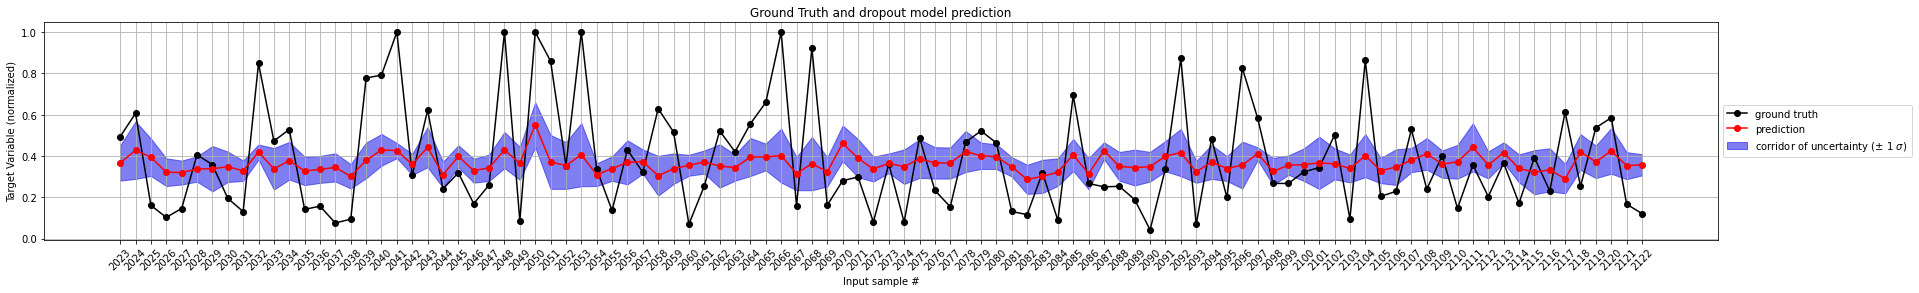

In [ ]:

start_index = np.random.randint(test_data.shape[0]-150)
print('start index \n ', start_index)

random = range(start_index, start_index+100)
print('random \n ', random) 

test_labels_plot= np.asarray([float(test_labels[i]) for i in random])
print('test labels plot \n ', test_labels_plot)

mean_plot = np.asarray([float(pred_mean[i]) for i in random])
std_plot = np.asarray([float(pred_std[i]) for i in random])

print('unique value of predicted standard deviation \n ', np.unique(std_plot))

plot_gt_vs_pred(test_labels_plot, mean_plot, std_plot, path+'output_plots/'+uncert_name+'_vs_prediction', random, uncert_name)

## GBP Logic

In [ ]:
def guided_bp(test_input, test_label, layer_name, model, num_samples_explanations_to_be_generated, input_id):
    @tf.custom_gradient
    def guidedRelu(x):
        #https://towardsdatascience.com/how-to-visually-explain-any-cnn-based-models-80e0975ce57
        def grad(dy):
            return tf.cast(dy>0,'float32') * tf.cast(x>0, 'float32') * dy
        return tf.nn.relu(x), grad

    LAYER_NAME = layer_name

    # create a model till last convolutional layers to have the best compromise between high-level semantics and detailed spatial information
    gb_model = tf.keras.models.Model(inputs = [model.input],    
                                     outputs = [model.get_layer(LAYER_NAME).output])
    #print('list of gbp_model layer name : ')
    #for i in gb_model.layers:
    #    print('layer_name_ ', i.name)
    
    layer_dict = [layer for layer in gb_model.layers[1:] if hasattr(layer,'activation')]
    

    #value = model.get_layer(LAYER_NAME).output.shape[-1]  # to compute the number of channels in the volume at a particular layer 

    for layer in layer_dict:
        if layer.activation == tf.keras.activations.relu:
            layer.activation = guidedRelu

    feature_weight_list = [] 
    list_of_outputs = [] 
    for i in range(num_samples_explanations_to_be_generated):
        print(f'Generating explanation # {i} for input # {input_id}')
        #print('xxxxxxxxxxxxxxxxxxxxxxxxxx')
        #print('Example to be explained : ' , test_input)
        with tf.GradientTape() as tape:
            inputs = tf.cast(test_input, tf.float32)
            tape.watch(inputs)
            # NO NEED TO RUN THIS (the if condition) AS VISUALIZATION OF ENSEMBLE HEATMAPS FOR INNER LAYER WOULD MAKE NO SENSE : FILTER IN EVERY INDIVIDUAL ENSEMBLE UNIT WOULD LEARN SOMETHING DIFFERENT EVERYTIMG
            # THIS THESIS NEEDS TO FOCUS ON FINAL LAYER HEATMAPS (AS THEY SHOULD BE SAME FOR A GIVEN INPUT ACROSS ENSEMBLES)
                    
            #outputs = gb_model.predict(inputs) 
            outputs = gb_model(inputs)
            print('gt : ', test_label)
            print('outputs : ',outputs.numpy())
            list_of_outputs.append(outputs.numpy())
            # essentially model() and model.predict() yield the same output with the difference that 
            # https://stackoverflow.com/questions/55308425/difference-between-modelx-and-model-predictx-in-keras#:~:text=The%20format%20may%20be%20different,its%20structure%2C%20weights%20and%20biases.
            #Today given a model in tensorflow 2.0 (built using the keras library), #out_np = model.predict(x) provides a numpy array which can, as an example, be printed with print(out_np).
            #On the other hand,out_tf = model(x) results into a tensorflow object, wich can be converted to a numpy array with .numpy()

    
        #print('feature_names ', feature_names)
        #print('outputs ', outputs)

        grads = tape.gradient(outputs, inputs)[0]# selecting that unit in dense layer that has the maximum activation for a given input,,,, if[0] not selected then shape of grads is: [1,32,32,3] 
        #print('grads \n', grads)

        grads = grads.numpy() #as the model(inputs) returns a tensor and this is eventually used in the gradient computation, for plotting purpose this needs to be converted in np

        # normalizing the value of computed gradient for each feature [04032022 update : no need to normalize the gradients as it is only useful for visualization in heatmap ]
        # in bar charts, the gradients can remain negative 
        #grads -= np.min(grads)
        #grads /= np.max(grads)
        
        #print('normalized_grads : ', grads)
        feature_weight_list.append(grads)
        #plot_explanation(grads_plot=grads, 
        #                 feature_names=feature_names,
        #                 sample_number=i, 
        #                 err=None, 
        #                 save_file_path=path+'output_plots/explanation_for_sample_number_'+str(i)+'_input_id_'+str(sample_id))   

    return feature_weight_list, list_of_outputs
    #print('feature_weight_list : ', feature_weight_list)
    #feature_weight_arr =  np.asarray(feature_weight_list)
    #feature_weight = np.reshape(feature_weight_arr, (num_samples_explanations_to_be_generated, -1))
    # the mean and the std of the different explanations of the samples is computed here 
    #mean_feature_weight = np.mean(feature_weight_arr, axis=0)
    #std_feature_weight = np.std(feature_weight_arr, axis=0)

    #print(mean_feature_weight)
    #print(std_feature_weight)
    
    #print('len of outputs : ', len(list_of_outputs))
    #mean_output = np.mean(list_of_outputs)
    #std_output = np.std(list_of_outputs)

    #mean_output = str(round(mean_output, 3))
    #std_output = str(round(std_output, 3))
    #test_label = str(round(float(test_label), 3))

    #print('mean_output ', mean_output)
    #print('std_output ', std_output)
    #print('test_label ', test_label)

    #plot_explanation(grads_plot=mean_feature_weight,
    #                 feature_names=feature_names, 
    #                 sample_number=None, 
    #                 err=std_feature_weight,
    #                 save_file_path=path+'output_plots/combined_explanation_of_'+str(num_samples_explanations_to_be_generated)+'_samples_for_input_id_'+str(sample_id),
    #                 combination_title=[mean_output, std_output, test_label])
    
    #return mean_feature_weight, std_feature_weight, feature_weight #returning feature_weight in order to visualize and analyse the behaviour of distribution

In [ ]:
number_of_explanations_per_input = 10
number_of_inputs_to_be_explained = test_data.shape[0]

list_of_input_to_be_explained = [] 
list_of_input_gt = [] 

list_of_gbp_explanation = [] 
list_of_gbp_prediction = []

start = time.time() 

print(test_data.shape)

count = 1
for input, label in zip(test_data, test_labels):
    
    #print('input \n ', input) 
        
    input = np.expand_dims(input, axis=0)
    
    feature_weight_for_a_single_input, outputs_for_a_single_input = guided_bp(input,
                                                         label, 
                                                         'dense_3',
                                                         stochastic_model, 
                                                         num_samples_explanations_to_be_generated=number_of_explanations_per_input,
                                                         input_id=count)
                                                        
    #print('label \n', label)
    #print('outputs \n', outputs_for_a_single_input)
    list_of_input_to_be_explained.append(input)
    list_of_input_gt.append(label)

    list_of_gbp_explanation.append(feature_weight_for_a_single_input)
    list_of_gbp_prediction.append(outputs_for_a_single_input)

    count+=1
    print('xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx')
    #break
end = time.time() 

Streaming output truncated to the last 5000 lines.
gt :  [0.63832327]
outputs :  [[0.5379952]]
Generating explanation # 8 for input # 2839
gt :  [0.63832327]
outputs :  [[0.35537255]]
Generating explanation # 9 for input # 2839
gt :  [0.63832327]
outputs :  [[0.23104465]]
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
Generating explanation # 0 for input # 2840
gt :  [0.38031334]
outputs :  [[0.41594696]]
Generating explanation # 1 for input # 2840
gt :  [0.38031334]
outputs :  [[0.4745021]]
Generating explanation # 2 for input # 2840
gt :  [0.38031334]
outputs :  [[0.22285347]]
Generating explanation # 3 for input # 2840
gt :  [0.38031334]
outputs :  [[0.394045]]
Generating explanation # 4 for input # 2840
gt :  [0.38031334]
outputs :  [[0.38705]]
Generating explanation # 5 for input # 2840
gt :  [0.38031334]
outputs :  [[0.38705]]
Generating explanation # 6 for input # 2840
gt :  [0.38031334]
outputs :  [[0.41001695]]
Generating explanation # 7 for input # 2840
gt :  [0.38031334]
outputs :  [[0.

## Save inputs to be explained

In [ ]:
print('time elapsed to generate explanations (seconds) ', end-start) 

#saving the input to be explained as np array 
np.save(os.path.join(explanation_path, f'GBP_list_of_input_to_be_explained.npy'),
        list_of_input_to_be_explained,
        allow_pickle=True)

#save the corresponding ground truth
np.save(os.path.join(explanation_path, f'GBP_list_of_input_gt.npy'),
        list_of_input_gt,
        allow_pickle=True)

time elapsed to generate explanations (seconds)  258.47718143463135


## Save GBP explanations

In [ ]:
#save the explanations 
np.save(os.path.join(explanation_path, f'list_of_gbp_explanation.npy'),
        list_of_gbp_explanation,
        allow_pickle=True)

#save the model prediction 
np.save(os.path.join(explanation_path, f'list_of_gbp_prediction.npy'),
        list_of_gbp_prediction,
        allow_pickle=True)

## Plt explanation code

In [ ]:
# code for horizontal bar chart 

def plot_explanation(grads_plot, feature_names, sample_number=None, err=None, save_file_path=None, combination_title=None):
    plt.figure(figsize=(15, 10))
    #plt.barh(pos, vals, color=colors) #this code works well but does not have legend or text in int

    print('grads_plot ', list(grads_plot))
    colors = ['C1' if x > 0 else 'C0' for x in list(grads_plot)] # originally negative=red and positive=green (coloring scheme)
    colors_set = set(colors)
    #print('colors_set before ', colors_set)
    colors_set = ['positive' if c == 'C1' else 'negative' for c in colors_set]
    #print('colors_set after ', colors_set)
    exp = list(grads_plot)
    pos = np.arange(len(exp)) + .5
    #print('pos values for plot are ', pos)

    vals = [float(x) for x in exp]
    vals_str = [str(round(val, 3)) for val in vals]
    #print('vals_str ', vals_str)

    #colors = ['r', 'g', 'b']
    labels = colors_set 
    legend_colors = list(set(colors))
    #print(legend_colors)
    handles = [plt.Rectangle((0,0),1,1, color=legend_colors[label]) for label in range(len(labels))]
    #print(handles)

    vals = [np.abs(num) if num  == 0 else num for num in vals] # removing the sign from 0 vals
    #print('vals ', vals)

    #max_horizontal_value_to_plot_text_box = np.max(vals)

    for i, v in enumerate(vals):
        if err is None:
            # in case the text box needs to be moved along the bar then switch 0 to v
            plt.text(v, i+0.5, str(round(v, 3)), Bbox = dict(facecolor = 'grey', alpha =0.2)) # https://www.geeksforgeeks.org/adding-value-labels-on-a-matplotlib-bar-chart/

        elif err is not None:
            # in case of the combined explanation, the text box should contain the mean+-std as well
            plt.text(v, i+0.7, str(round(v, 3))+'$\pm$'+str(round(err[i], 3)), Bbox = dict(facecolor = 'grey', alpha =0.2))

    axx = plt.barh([i for i in pos], vals, xerr=err, align='center', color=colors) # this code appropriate legend

    plt.grid(alpha=0.5)
    plt.ylabel('feature names')
    plt.xlabel('feature coefficient')
    plt.yticks(pos, feature_names[:-1])

    if err is not None:
        error = plt.plot([], label='corridor of uncertainty ($\pm \sigma$)', linewidth=3, linestyle='-', color='k')
        plt.title(f'combined explanation , prediction : {combination_title[0]} $\pm$ {combination_title[1]} , GT : {combination_title[2]}')
        main_bars = [plt.Rectangle((0,0),1,1, color=legend_colors[label]) for label in range(len(labels))]
        #first_legend = plt.legend(handles=error)
        #second_legend = plt.legend(handles=main_bar)

        handles = error + main_bars #https://stackoverflow.com/questions/28732845/combine-two-pyplot-patches-for-legend       
        error_label = ['corridor of uncertainty ($\pm \sigma$)']
        main_bars_label = colors_set

        labels = error_label + main_bars_label
        plt.legend(handles, labels)

    else:
        handles=[plt.Rectangle((0,0),1,1, color=legend_colors[label]) for label in range(len(labels))]
        plt.title(f'explanation for sample_number {sample_number}')
        plt.legend(handles, labels) # https://stackoverflow.com/questions/57340415/matplotlib-bar-plot-add-legend-from-categories-dataframe-column

    plt.subplots_adjust()
    plt.savefig(save_file_path+'.pdf')
    plt.savefig(save_file_path+'.png')

## Test the quality of generated GBP explanation (sample few inputs and view the explanations)

inputs shape  (3000, 1, 8)
gt labels shape  (3000, 1)
gbp explanation shape  (3000, 10, 8)
list of gbp outputs shape  (3000, 10, 1, 1)
explanation  0
grads_plot  [0.04128439, -0.10125556, 0.1802762, 0.022905337, 0.15376349, 0.1299802, -0.17996421, 0.2377758]
explanation  1
grads_plot  [0.04128439, -0.10125556, 0.1802762, 0.022905337, 0.15376349, 0.1299802, -0.17996421, 0.2377758]
explanation  2
grads_plot  [0.035866126, 0.017818972, 0.05467724, -0.007442436, 0.06344233, 0.052299, -0.053039864, 0.004744239]
explanation  3
grads_plot  [0.035866126, 0.017818972, 0.05467724, -0.007442436, 0.06344233, 0.052299, -0.053039864, 0.004744239]
explanation  4
grads_plot  [-0.033279024, -0.03066717, 0.09593274, -0.10580401, 0.12634566, 0.024800953, 0.00041297296, 0.093006]
explanation  5
grads_plot  [0.04001617, -0.09869403, 0.17591769, 0.021774722, 0.15026361, 0.1266208, -0.17514306, 0.23186325]
explanation  6
grads_plot  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
explanation  7
grads_plot  [0.0, 0.

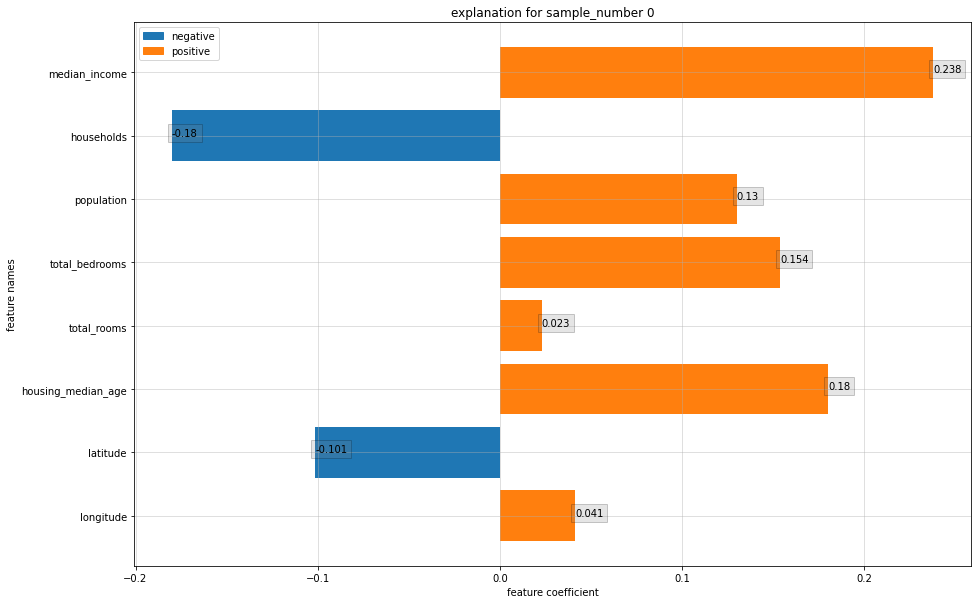

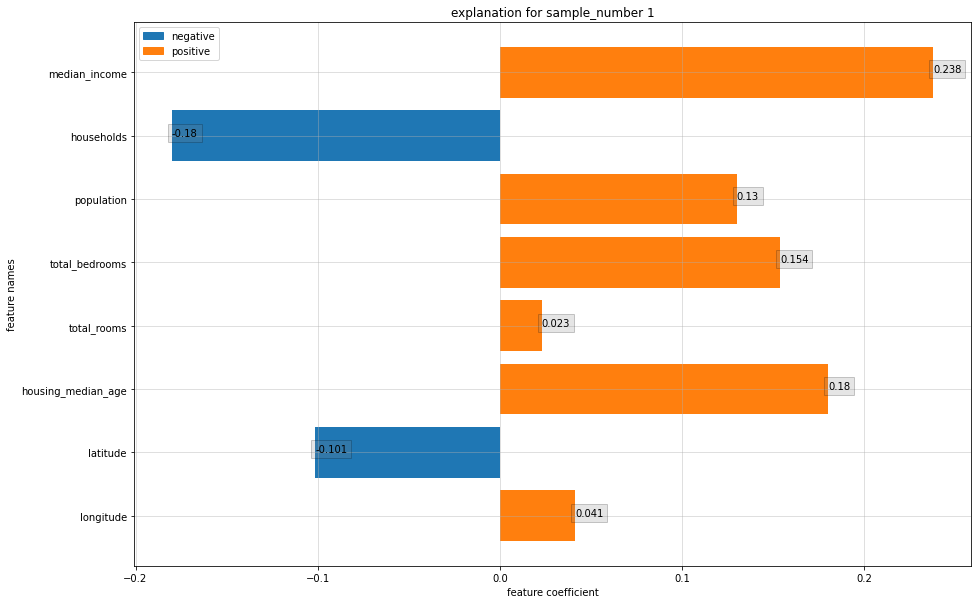

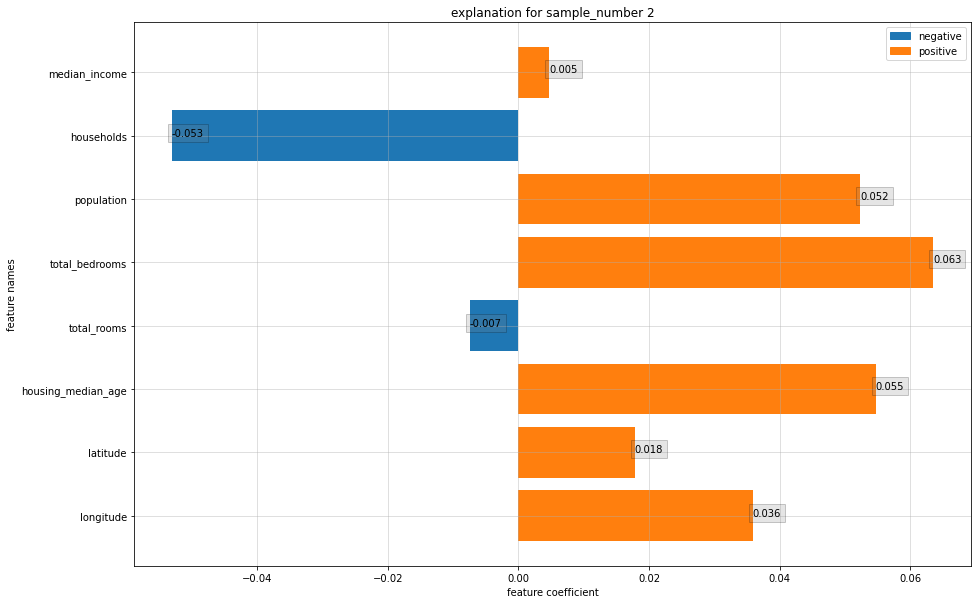

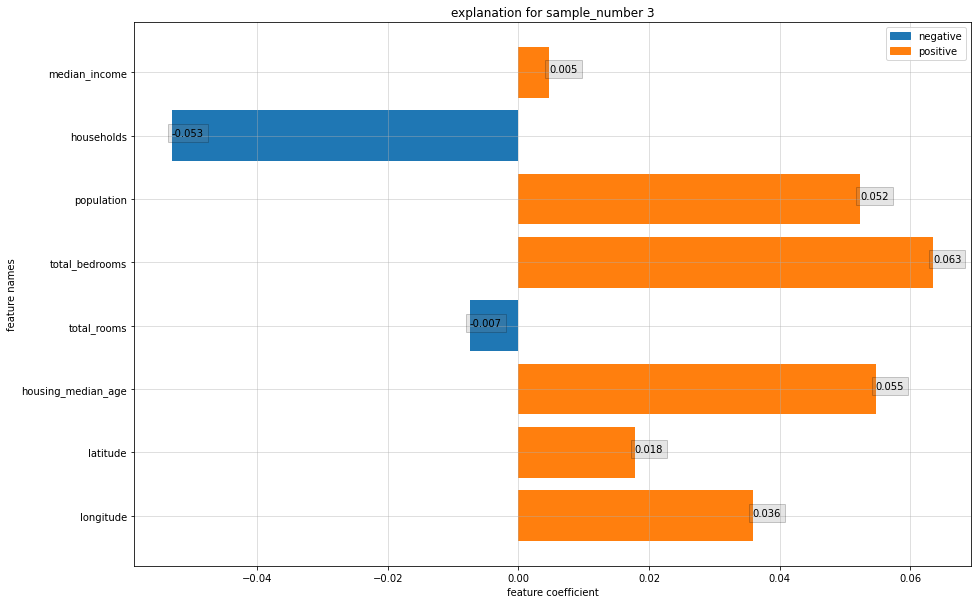

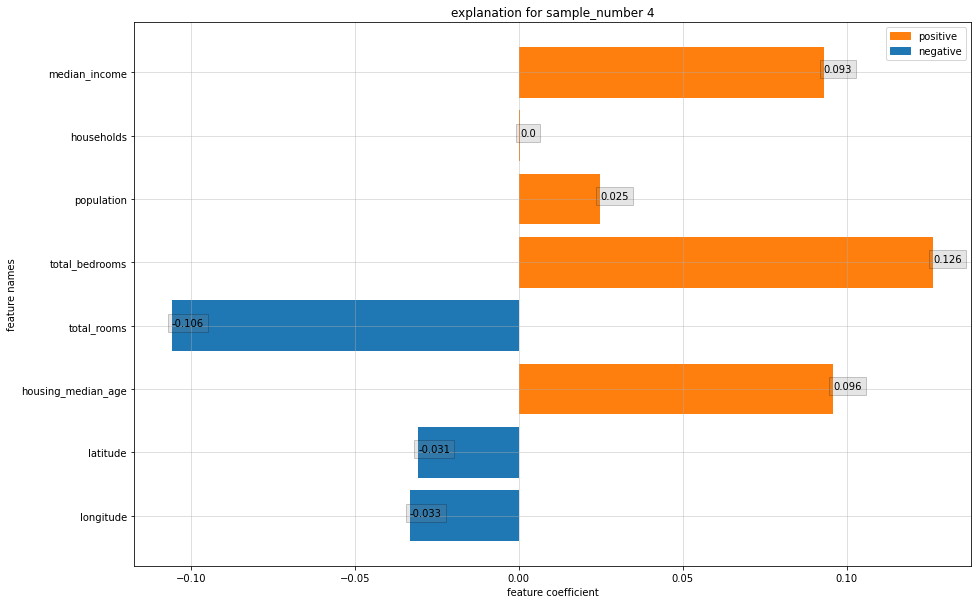

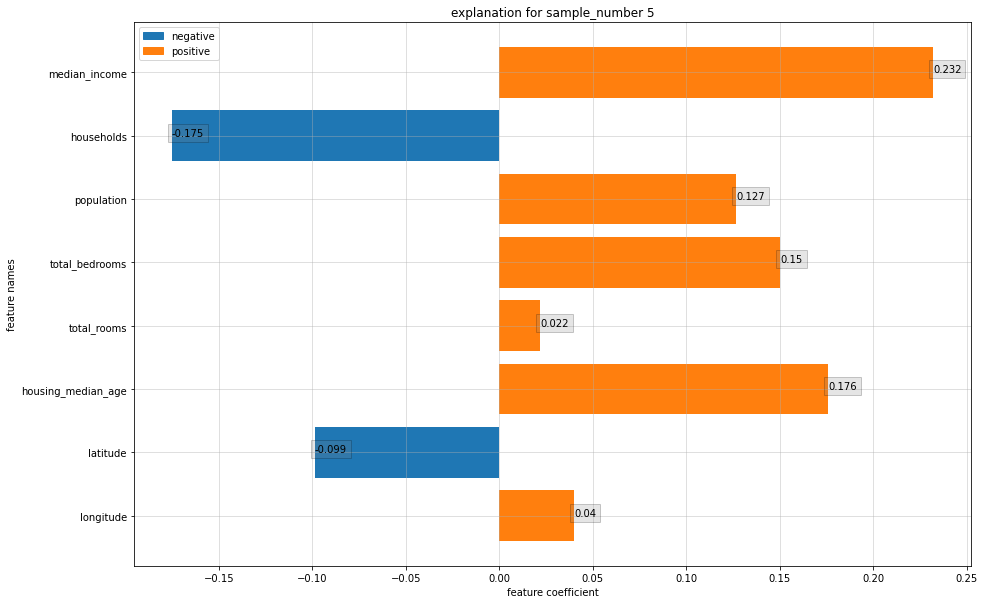

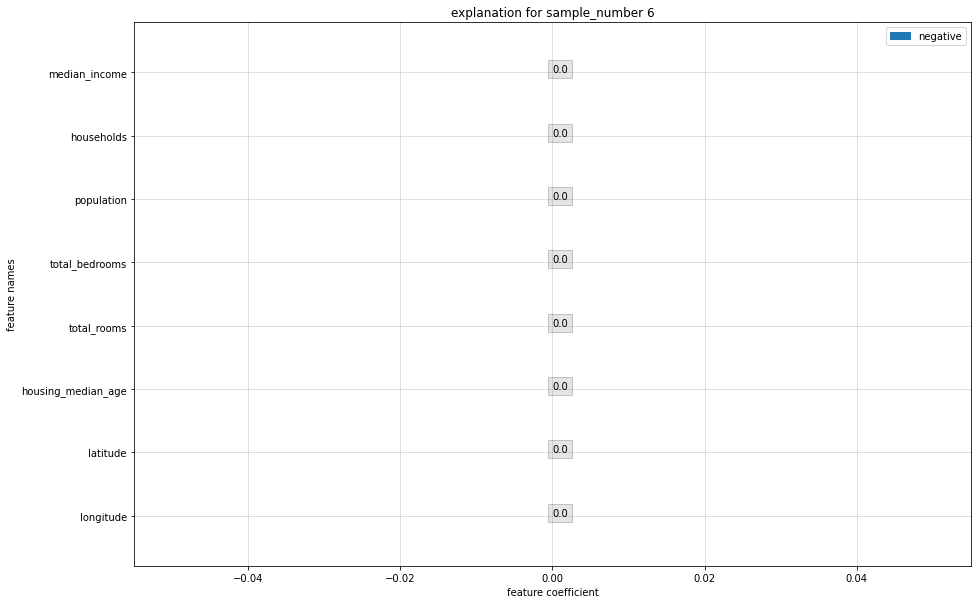

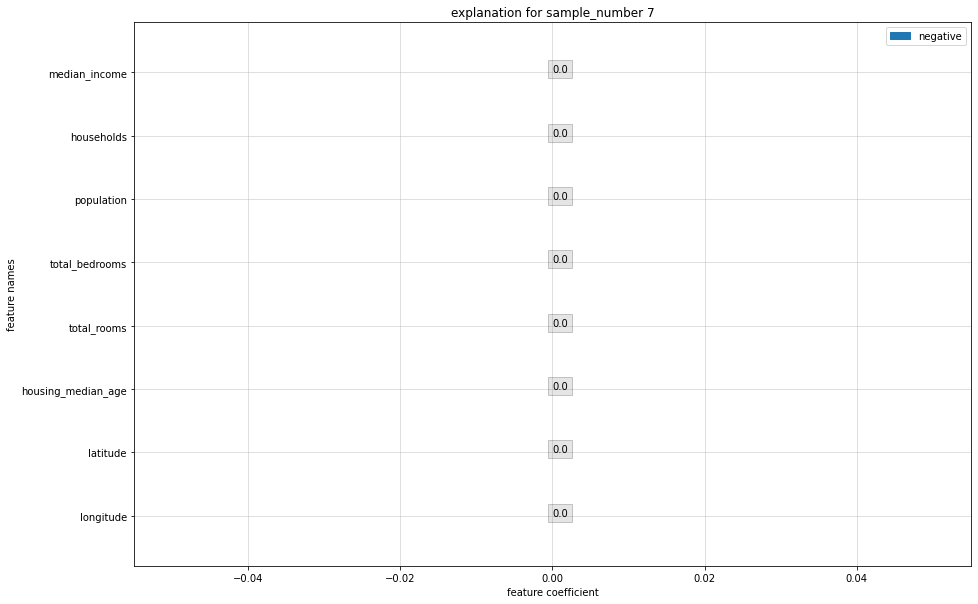

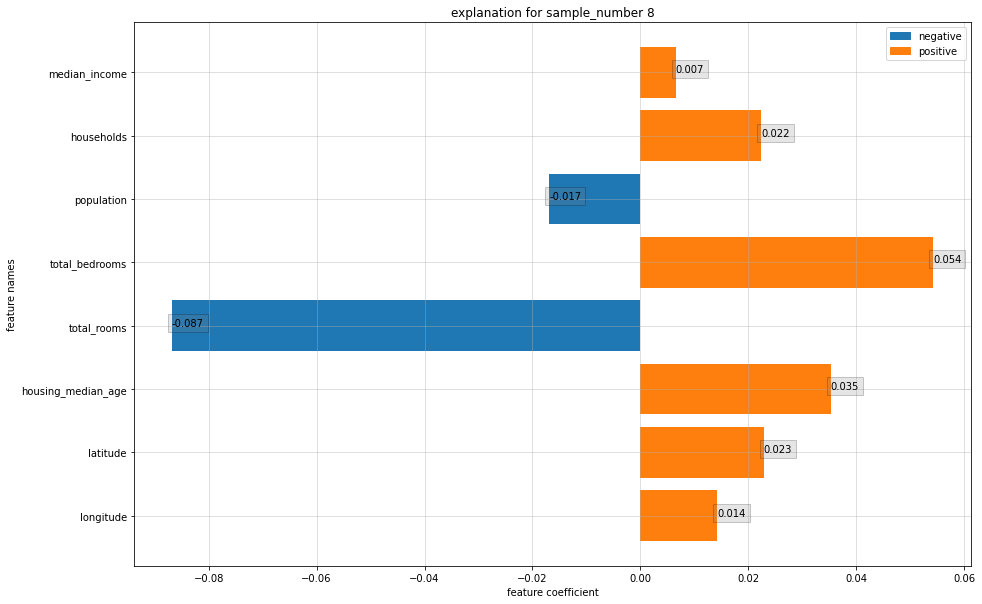

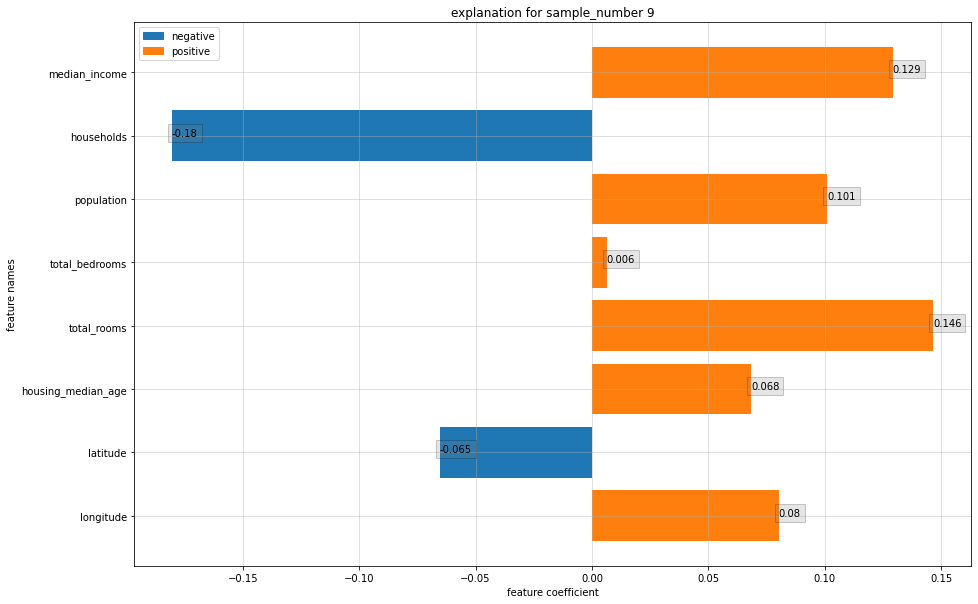

In [ ]:
inputs = np.load(os.path.join(explanation_path, f'GBP_list_of_input_to_be_explained.npy'))
print('inputs shape ', inputs.shape)

gt_labels = np.load(os.path.join(explanation_path, f'GBP_list_of_input_gt.npy'))
print('gt labels shape ', gt_labels.shape)


gbp_explanations = np.load(os.path.join(explanation_path, f'list_of_gbp_explanation.npy'))
print('gbp explanation shape ', gbp_explanations.shape)

list_of_gbp_outputs = np.load(os.path.join(explanation_path, f'list_of_gbp_prediction.npy'))
print('list of gbp outputs shape ', list_of_gbp_outputs.shape)


number_of_inputs_to_be_visualized = 1

for input in range(gbp_explanations.shape[0]):
    if input >= number_of_inputs_to_be_visualized:
        break

    for explanation in range(gbp_explanations[input].shape[0]):
        print('explanation ', explanation)
        plot_explanation(gbp_explanations[input][explanation], 
                         feature_names, 
                         save_file_path=os.path.join(explanation_heatmap_path, f'input_id_{input}_explanation_id_{explanation}'),
                         sample_number=explanation)
        
    
    print('input ', input)
    
    print('xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx')

## Coefficient of Variation

In [ ]:
'''
# coefficient of variation / relative standard deviation (RSD) (sigma divided by mu) 
# https://link.springer.com/chapter/10.1007/978-3-642-80328-4_13 [source that 30% cv could act as a threshold]
# https://en.wikipedia.org/wiki/Coefficient_of_variation
# https://www.formpl.us/blog/coefficient-variation

print('mean_feature_weight ', mean_feature_weight)
print('std_feature_weight ', std_feature_weight)
print('feature_names ', feature_names)

eps=1e-3
# compute coefficient of variation 
coefficient_of_variation = [100*(i/(j+eps)) if -0.001<j<0.001 else 100*(i/j) for i,j in zip(std_feature_weight, mean_feature_weight)]
print('coefficient_of_variation ', coefficient_of_variation)

plt.figure(figsize=(15, 10))
colors = ['C1' if x > 0 else 'C0' for x in list(coefficient_of_variation)] # originally negative=red and positive=green (coloring scheme)
colors_set = set(colors)
legend_colors = list(set(colors))
colors_set = ['positive' if c == 'C1' else 'negative' for c in colors_set]

bars = [plt.Rectangle((0,0),1,1, color=legend_colors[label]) for label in range(len(colors_set))]
#uncomment the next 2 line in case cv threshold is needed 
#thresh = plt.plot([], label='threshold', linewidth=3, linestyle='-', color='k')
#handles = bars + thresh

main_bars_label = colors_set

# uncomment following two lines in case cv threshold is needed
#error_label = ['threshold']
#labels = main_bars_label + error_label 

# uncomment following two lines to remove threshold
handles = bars 
labels = main_bars_label

plt.bar(feature_names[:-1], coefficient_of_variation, color=colors)
# uncomment the following 2 lines to get the threshold lines
#plt.plot(feature_names[:-1], [30]*len(feature_names[:-1]), '--k')
#plt.plot(feature_names[:-1], [-30]*len(feature_names[:-1]), '--k')
plt.xticks(rotation=90)
plt.xlabel('feature name')
plt.ylabel(r'coefficient of variation : 100 $\times$ ($\sigma$ / $\mu$ )%')
plt.grid(alpha=0.2) 


plt.legend(handles, labels)
plt.title('feature name v/s coefficient of variation')

for i, v in enumerate(coefficient_of_variation):
    # in case the text box needs to be moved along the bar then switch 0 to v
    plt.text(i-0.2, v, str(round(v, 3)), Bbox = dict(facecolor = 'grey', alpha =0.2)) # https://www.geeksforgeeks.org/adding-value-labels-on-a-matplotlib-bar-chart/

plt.savefig(path+'output_plots/feature_name_vs_coefficient_of_variation_'+
            str(test_sample_index)+'.pdf', bbox_inches='tight')
plt.savefig(path+'output_plots/feature_name_vs_coefficient_of_variation_'+
            str(test_sample_index)+'.png', bbox_inches='tight')

#https://en.wikipedia.org/wiki/Kurtosis
'''

"\n# coefficient of variation / relative standard deviation (RSD) (sigma divided by mu) \n# https://link.springer.com/chapter/10.1007/978-3-642-80328-4_13 [source that 30% cv could act as a threshold]\n# https://en.wikipedia.org/wiki/Coefficient_of_variation\n# https://www.formpl.us/blog/coefficient-variation\n\nprint('mean_feature_weight ', mean_feature_weight)\nprint('std_feature_weight ', std_feature_weight)\nprint('feature_names ', feature_names)\n\neps=1e-3\n# compute coefficient of variation \ncoefficient_of_variation = [100*(i/(j+eps)) if -0.001<j<0.001 else 100*(i/j) for i,j in zip(std_feature_weight, mean_feature_weight)]\nprint('coefficient_of_variation ', coefficient_of_variation)\n\nplt.figure(figsize=(15, 10))\ncolors = ['C1' if x > 0 else 'C0' for x in list(coefficient_of_variation)] # originally negative=red and positive=green (coloring scheme)\ncolors_set = set(colors)\nlegend_colors = list(set(colors))\ncolors_set = ['positive' if c == 'C1' else 'negative' for c in col

## TESTING SECTION 

In [ ]:
#for i in range(8):
#for i in range(8):
#    plt.hist(feature_weight[:,i])
#    plt.show()

In [ ]:
'''
%tensorflow_version 1.x
import tensorflow as tf 
t = tf.constant([[1, 2], [4, 8]])
print(t)
print(type(t))
a = t.eval(session=tf.compat.v1.Session())
print(a)
print(type(a))
'''

'\n%tensorflow_version 1.x\nimport tensorflow as tf \nt = tf.constant([[1, 2], [4, 8]])\nprint(t)\nprint(type(t))\na = t.eval(session=tf.compat.v1.Session())\nprint(a)\nprint(type(a))\n'

In [ ]:
'''
m = Sequential()
m.add(Dense(2, activation='relu'))
m.add(Dense(2, activation='relu'))
m.add(Dense(1, activation='relu'))

m.compile(loss='mse', metrics=['mae'], optimizer='rmsprop')

history = m.fit(train_data, 
                train_labels, 
                epochs=10, 
                verbose=2, 
                validation_data=(val_data, val_labels))

plt.plot(history.history['loss'], label='training_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

plt.plot(history.history['mae'], label='training_mae')
plt.plot(history.history['val_mae'], label='val_mae')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('mae')
plt.show()

output = m.predict(test_data)
print(output.shape)
'''

"\nm = Sequential()\nm.add(Dense(2, activation='relu'))\nm.add(Dense(2, activation='relu'))\nm.add(Dense(1, activation='relu'))\n\nm.compile(loss='mse', metrics=['mae'], optimizer='rmsprop')\n\nhistory = m.fit(train_data, \n                train_labels, \n                epochs=10, \n                verbose=2, \n                validation_data=(val_data, val_labels))\n\nplt.plot(history.history['loss'], label='training_loss')\nplt.plot(history.history['val_loss'], label='val_loss')\nplt.legend()\nplt.xlabel('epochs')\nplt.ylabel('loss')\nplt.show()\n\nplt.plot(history.history['mae'], label='training_mae')\nplt.plot(history.history['val_mae'], label='val_mae')\nplt.legend()\nplt.xlabel('epochs')\nplt.ylabel('mae')\nplt.show()\n\noutput = m.predict(test_data)\nprint(output.shape)\n"

In [ ]:
# test code to see the difference between model.predict(inputs) and model(inputs) 
# important difference between model.predict(inputs) and model(inputs) 
'''
test_input = test_data[0] 
test_input = np.expand_dims(test_input, axis=0)

for i in range(5):
    with tf.GradientTape() as tape:
        inputs = tf.cast(test_input, tf.float32)
        print('inputs ', inputs)
        tape.watch(inputs)
        
        #outputs = m.predict(inputs) # using this throws an error : No gradient defined for operation'IteratorGetNext' (op type: IteratorGetNext).
        #even for a straightforward dense model 
        outputs = m(inputs)
        print('outputs ', outputs)
        grads = tape.gradient(outputs, inputs)[0]
        
        print('grads ', grads)
        print('xxxxxxxxxxxxx')

'''

"\ntest_input = test_data[0] \ntest_input = np.expand_dims(test_input, axis=0)\n\nfor i in range(5):\n    with tf.GradientTape() as tape:\n        inputs = tf.cast(test_input, tf.float32)\n        print('inputs ', inputs)\n        tape.watch(inputs)\n        \n        #outputs = m.predict(inputs) # using this throws an error : No gradient defined for operation'IteratorGetNext' (op type: IteratorGetNext).\n        #even for a straightforward dense model \n        outputs = m(inputs)\n        print('outputs ', outputs)\n        grads = tape.gradient(outputs, inputs)[0]\n        \n        print('grads ', grads)\n        print('xxxxxxxxxxxxx')\n\n"